# Tree building W celltype-specific model

Here I run the celltype-specific model on patient W. Even though, there seem to be very small differences in fraction of reads in chr8 across cell types (except for plasma cells), it would still be interesting to analyse the output of the model.

## Import packages 



<br>



In [1]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os
import pickle
import collections


import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [2]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
#torch.set_default_tensor_type(torch.FloatTensor)
#torch.autograd.set_detect_anomaly(True)
patient = "AKLW_ct_priors"

## Load data

In [3]:
# load data from patient W
with open("/home/veltenlab/cluster/project/AML/clonal_analysis_joint/prob_modelling/data/"+patient+".json") as f:
    data = json.load(f)
       
# add type of mutations: 0 = CNV, 1 = nuclear, 2 = mitochondrial
data["type"] = np.array([1, 1, 1, 0])


In [4]:
data['colnames']

['KRAS', 'IDH2', 'NRAS', 'chr8']

# Build tree W

Here I heuristically build the clonal hierarchy of patient K

## Create tree class 


In [5]:
data_svi = {"M": torch.Tensor(data["M"]),
         "N": torch.Tensor(data["N"]),
         "mut_type": torch.Tensor([1,1,1,0]),
         "h_alpha": torch.Tensor([1000.0, 1000.0,1000.0, 2.]),
         "h_beta": torch.Tensor([1000.0,1000.0, 1000.0, 100.]),
         "af_alpha": torch.Tensor([[46, 22, 8, 12], [0,0,0,0]]),
         "af_beta": torch.Tensor([[100-46, 100-22, 100-8, 16], [1,1,1,1]]),
         "r_cnv": torch.Tensor([0,0,0,1.5]),
         "names": data["colnames"],
         "barcodes": data["cell_barcode"], 
         "umapx": data["umapx"], 
         "umapy": data["umapy"],
         "class_af": True, 
         "class_assign": torch.cuda.IntTensor(data["timepoint"]),
         "class_names": ["day0", "day15"],
         "cnv_celltype": True,                                         
         "celltype": torch.tensor(data["celltypes"])-1,
         "celltype_names": data["celltype_names"],
         "cnv_ct_mean": torch.Tensor(data["cnv_priors"]["mean"]),
         "cnv_ct_sd": torch.tensor(data["cnv_priors"]["sd"][0])}


In [6]:
t = tree(patient, data_svi)
t.sel_mutation(initial = True)

tensor([3, 0])

## Initial tree with chr8 & KRAS

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 1m 48s
Model fit to tree 1 in 1m 48s
Model fit to tree 2 in 1m 48s
Model fit to tree 3 in 1m 47s
Tree [0] selected for mutations ['chr8', 'KRAS']:
[tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])]
Total run time 0h 7m 12s


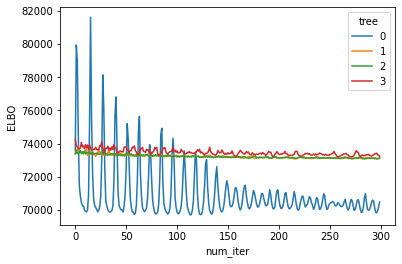

In [7]:
# add mutation and select the best tree(s)
t.select_tree(num_iter = 400, init = 100)

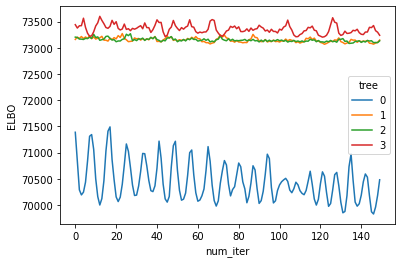

In [8]:
t.print_elbo(num_iter = 400, init = 250, include = [0,1,2,3])

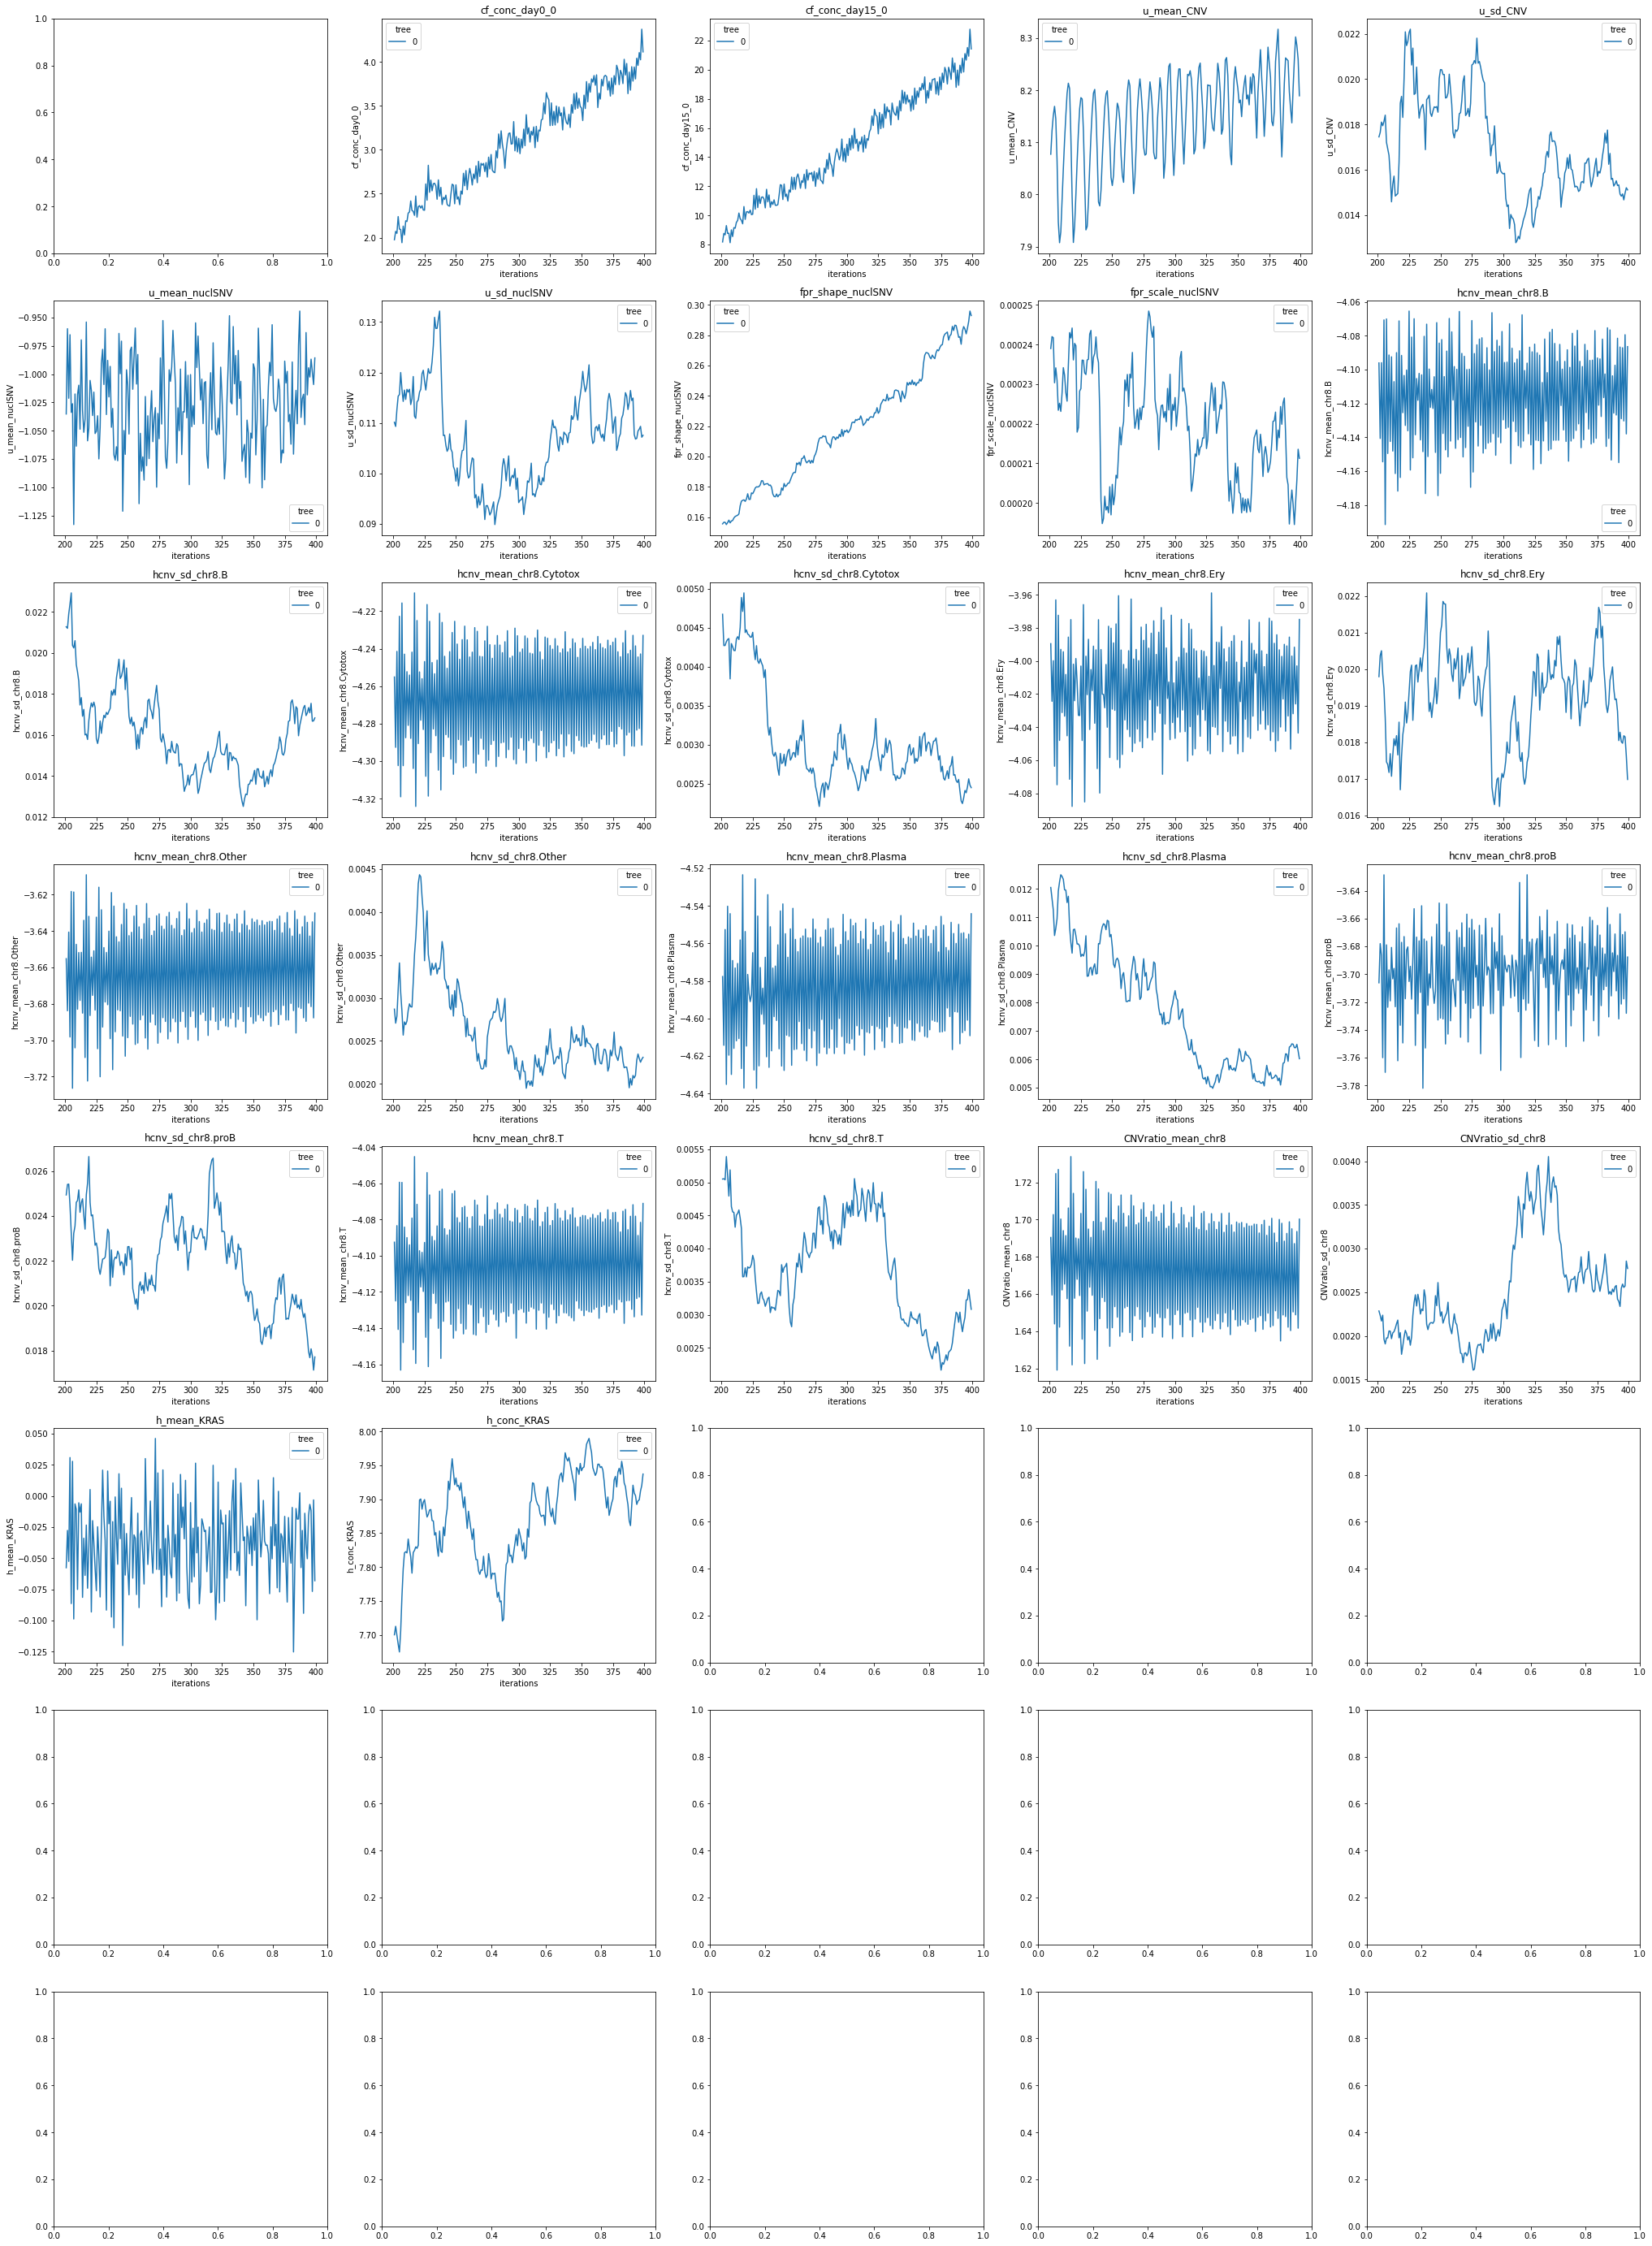

In [9]:
t.print_params(include = t.tree_indices, it = 200)

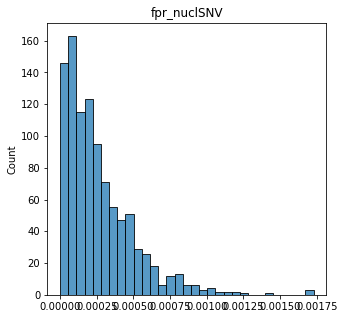

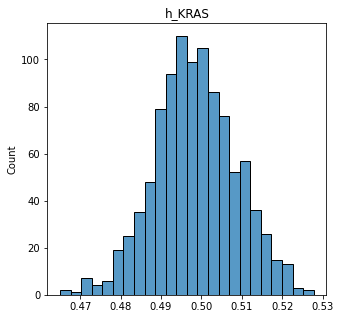

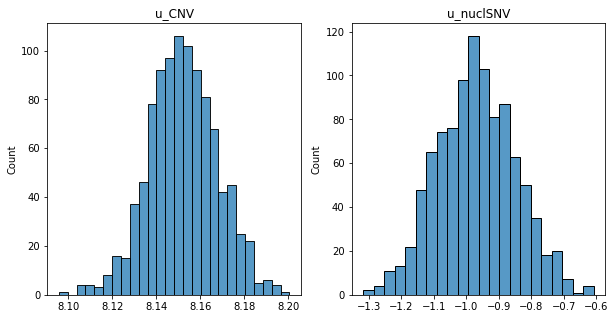

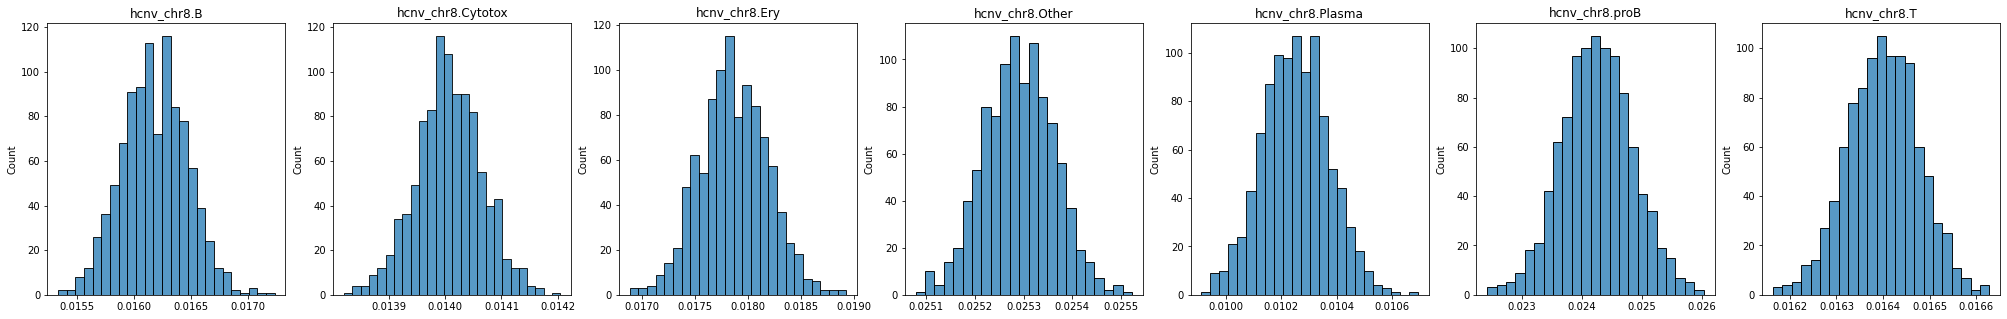

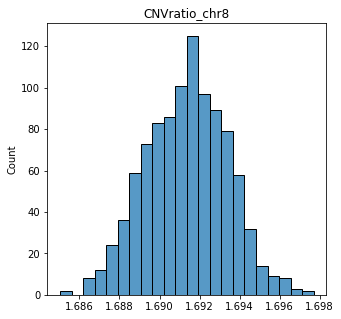

In [10]:
t.plot_posterior("all", 0, 1000)

## Add IDH2

IDH2 added to the tree
Choosing best tree among 7 potential candidates
Model fit to tree 0 in 2m 29s
Model fit to tree 1 in 2m 32s
Model fit to tree 2 in 2m 15s
Model fit to tree 3 in 2m 18s
Model fit to tree 4 in 2m 38s
Model fit to tree 5 in 2m 27s
Model fit to tree 6 in 1m 58s
Trees [1, 2, 4, 5, 6] selected for mutations ['chr8', 'KRAS', 'IDH2']
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
Total run time 0h 16m 40s


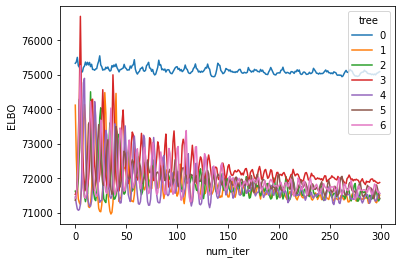

In [11]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 500, init = 200)

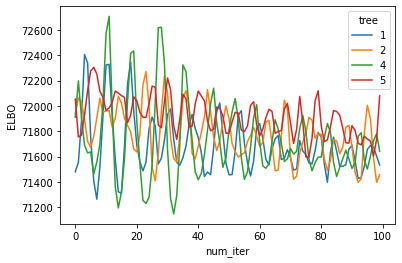

In [12]:
t.print_elbo(num_iter = 400, init = 300, include = [1,2,5,4])

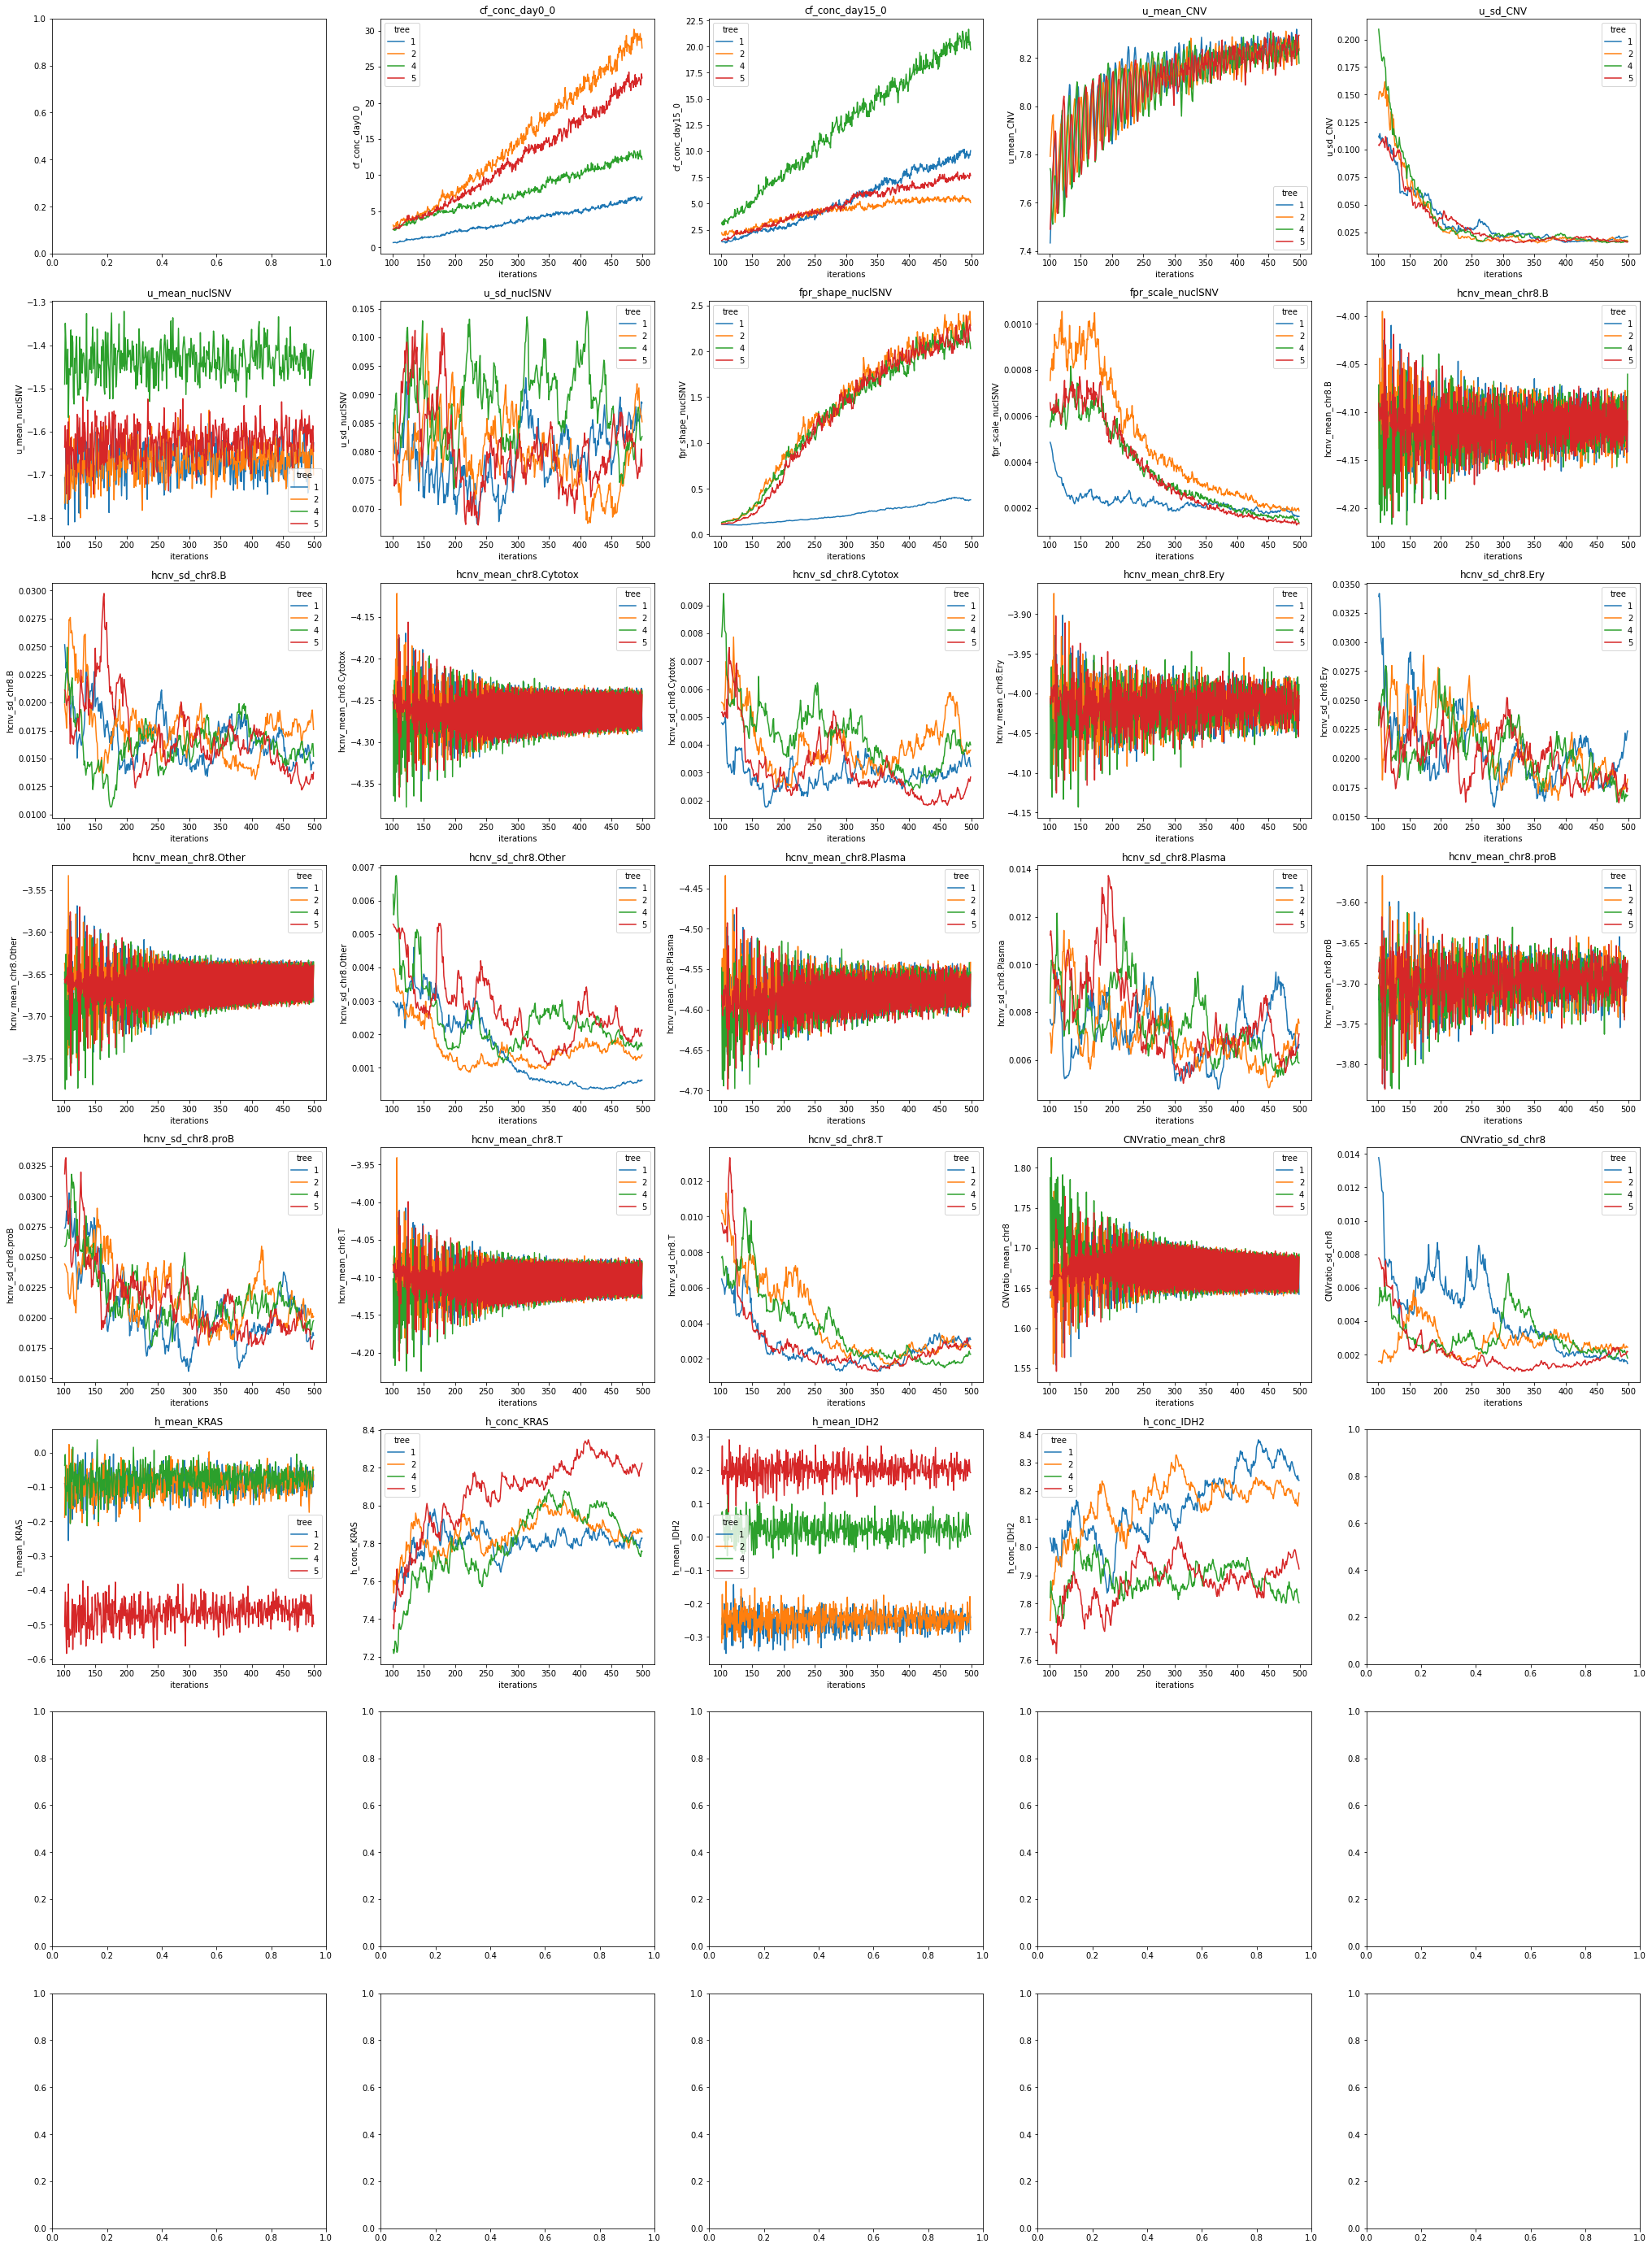

In [13]:
t.print_params(include = [1,2,5,4], it = 100)

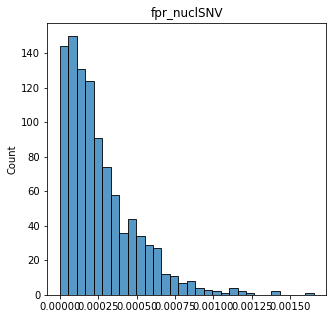

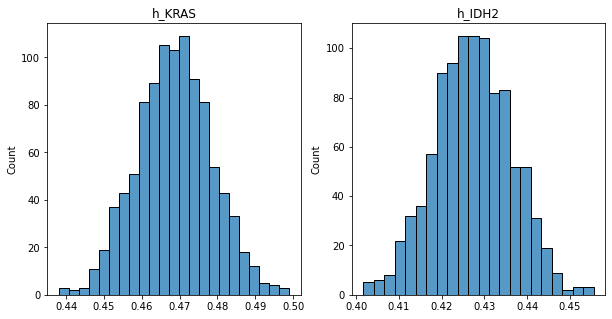

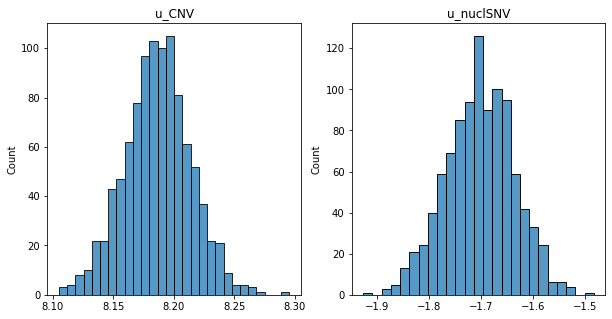

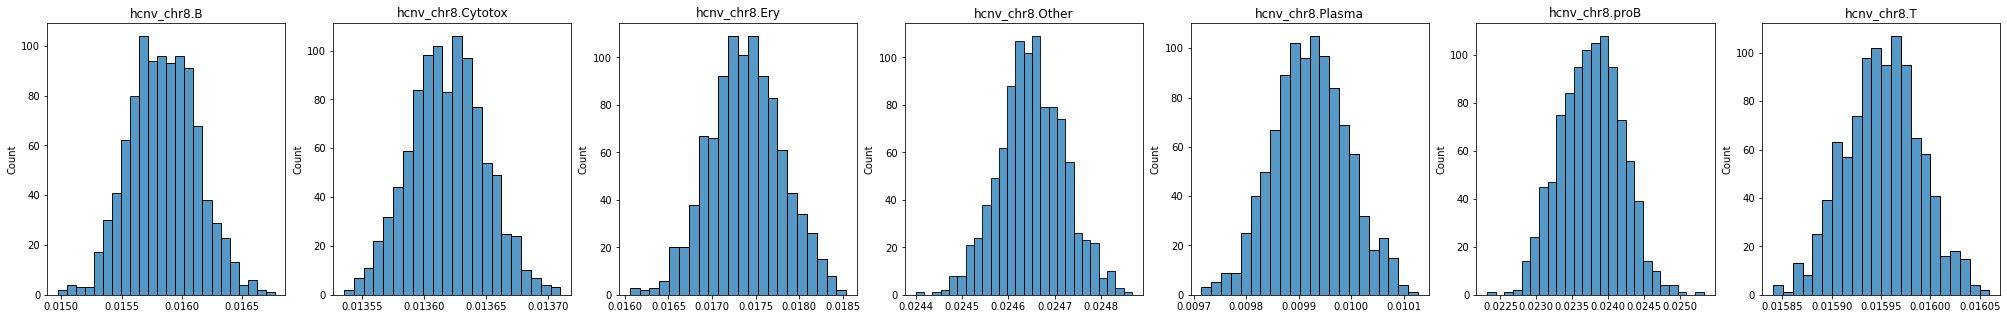

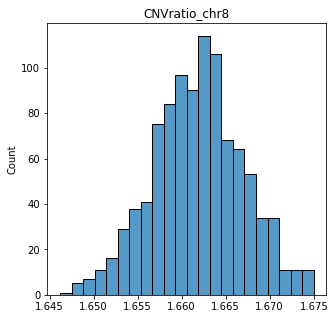

In [14]:
t.plot_posterior(variables = "all", tree = 1)

## Add NRAS

NRAS added to the tree
Choosing best tree among 44 potential candidates
Model fit to tree 0 in 2m 26s
Model fit to tree 1 in 2m 24s
Model fit to tree 2 in 2m 23s
Model fit to tree 3 in 2m 22s
Model fit to tree 4 in 2m 25s
Model fit to tree 5 in 2m 24s
Model fit to tree 6 in 2m 28s
Model fit to tree 7 in 2m 26s
Model fit to tree 8 in 2m 29s
Model fit to tree 9 in 2m 26s
Model fit to tree 10 in 2m 26s
Model fit to tree 11 in 2m 26s
Model fit to tree 12 in 2m 27s
Model fit to tree 13 in 2m 27s
Model fit to tree 14 in 2m 24s
Model fit to tree 15 in 2m 27s
Model fit to tree 16 in 2m 29s
Model fit to tree 17 in 2m 27s
Model fit to tree 18 in 2m 30s
Model fit to tree 19 in 2m 25s
Model fit to tree 20 in 2m 31s
Model fit to tree 21 in 2m 31s
Model fit to tree 22 in 2m 33s
Model fit to tree 23 in 2m 26s
Model fit to tree 24 in 2m 35s
Model fit to tree 25 in 2m 8s
Model fit to tree 26 in 2m 27s
Model fit to tree 27 in 2m 33s
Model fit to tree 28 in 2m 26s
Model fit to tree 29 in 2m 25s
Model fit

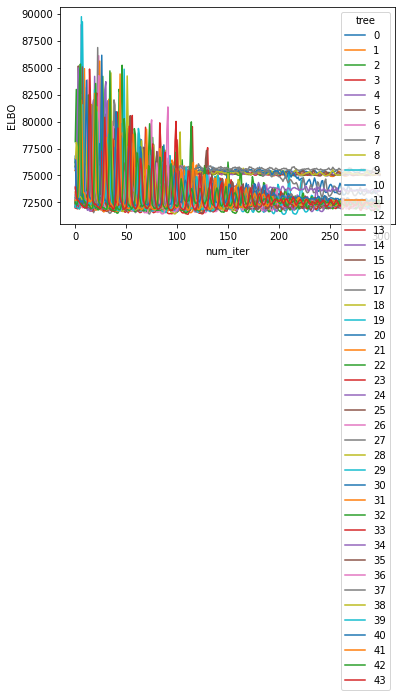

In [15]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 400, init = 100)

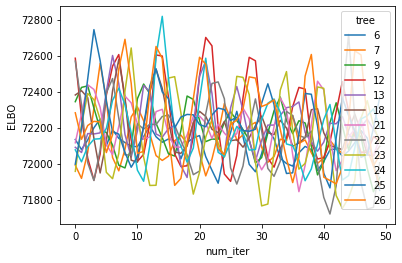

In [17]:
t.print_elbo(num_iter = 400, init = 350, include = t.tree_indices)

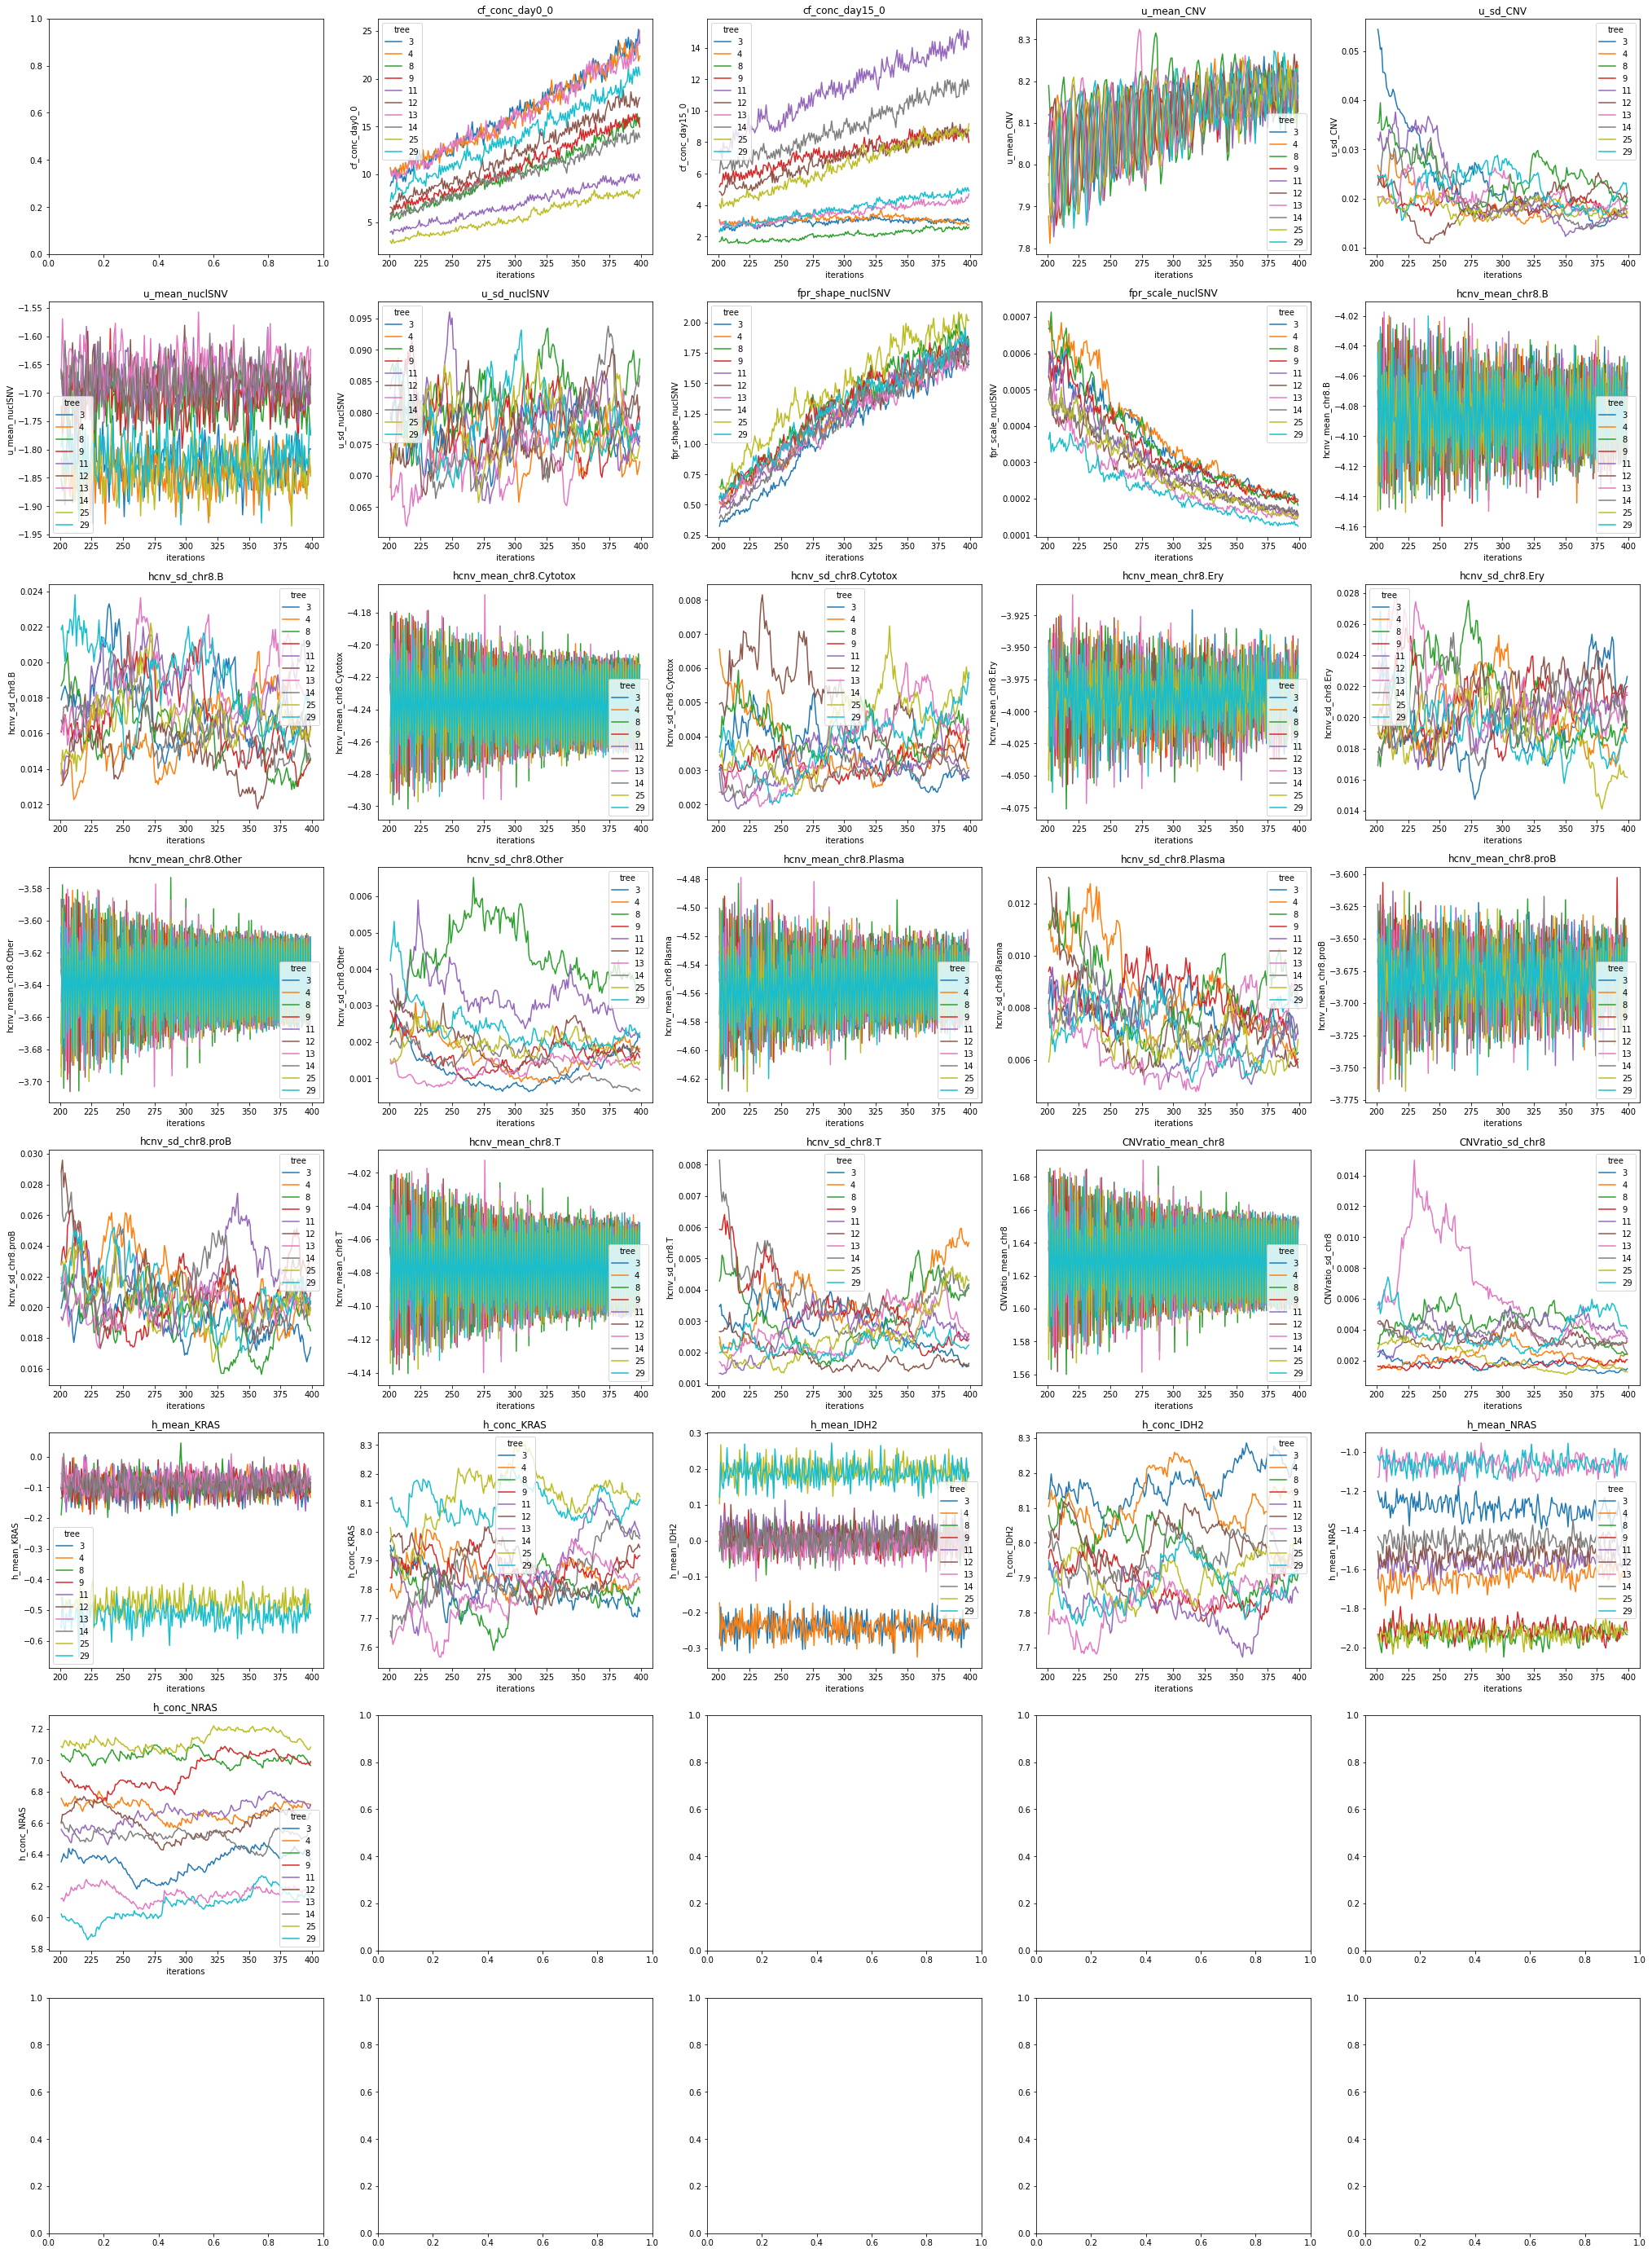

In [24]:
t.print_params(include = t.tree_indices, it = 200)

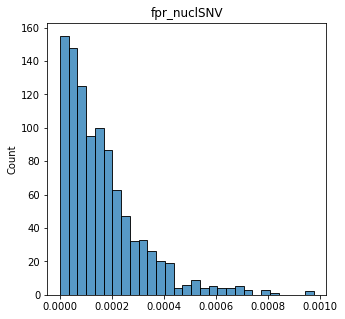

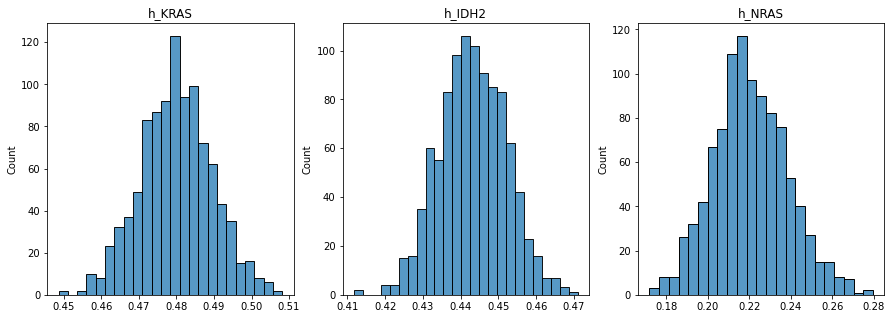

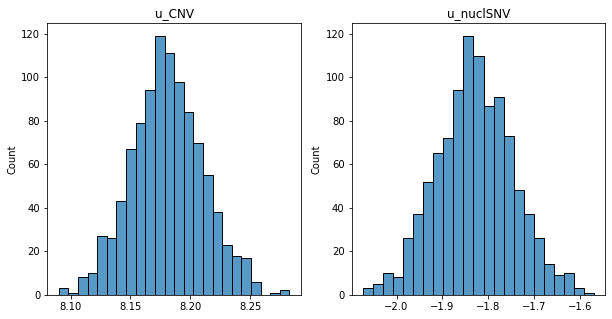

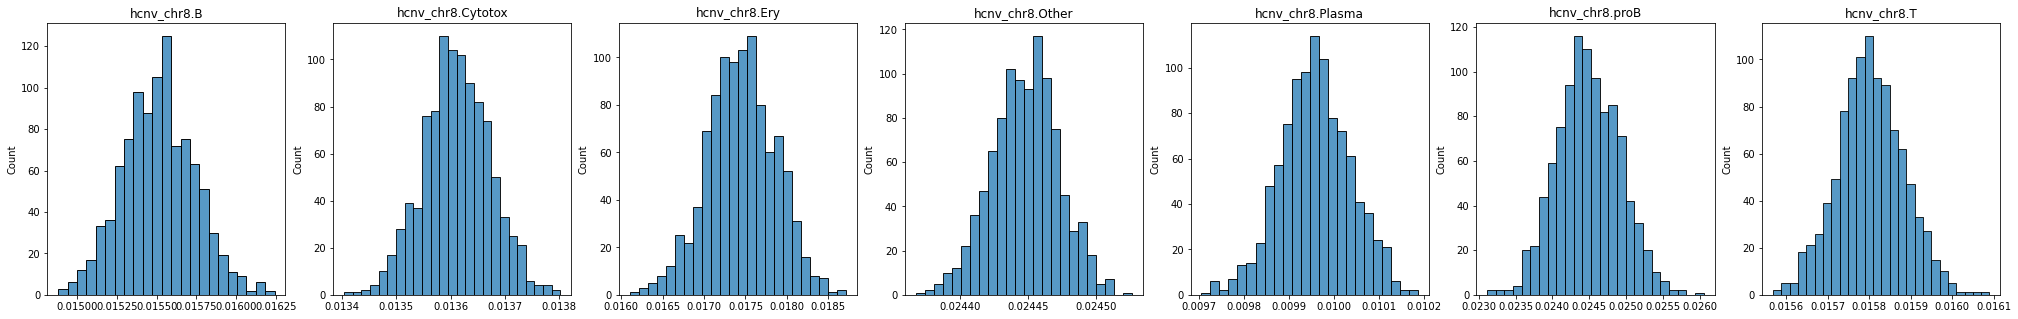

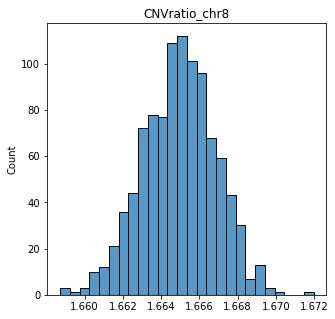

In [18]:
t.plot_posterior("all", 6, 1000)

# Compute clonal assignments

In [20]:
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 2m and 25s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 2m and 17s
Computing clonal assignment probabilities for tree 2
Clonal assignment probabilities computed in 2m and 28s
Computing clonal assignment probabilities for tree 3
Clonal assignment probabilities computed in 2m and 24s
Computing clonal assignment probabilities for tree 4
Clonal assignment probabilities computed in 2m and 25s
Computing clonal assignment probabilities for tree 5
Clonal assignment probabilities computed in 2m and 17s
Computing clonal assignment probabilities for tree 6
Clonal assignment probabilities computed in 2m and 23s
Computing clonal assignment probabilities for tree 7
Clonal assignment probabilities computed in 2m and 23s
Computing clonal assignment probabilities for tree 8
Clonal assignment probabilities computed in 2m and 42s
Computing clonal assignment 

# Get posterior predictive checks

In [ ]:
# get posterior predictive for tree: IDH2-trisomy-NRAS-KRAS (last 2 are mutually exclusive)
t.get_post_predictive(tree = 6, num_samples = t.M.shape[0])
with open("svi_objects/tree_"+t.name +".pickle", "wb") as f:
    pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# export object as pickle
t.export_pickle("svi_objects/"+t.name+".pickle")

Tree object saved as pickle!


In [21]:
t.name

'AKLW_ct_priors'